# Chapter 2. Programming Probabilistically

In [591]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

seed=4321

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system

## `numpyro` primer

In [592]:
trials = 4
theta_real = 0.35  # unknown value in a real experiment
# data = stats.bernoulli.rvs(p=theta_real, size=trials)
data = dist.Bernoulli(probs=theta_real).sample(random.PRNGKey(1), (trials,))
data

DeviceArray([0, 1, 0, 0], dtype=int32)

In [593]:
def model(data):
    # a priori
    θ = numpyro.sample('θ', dist.Beta(1., 1.))
    # likelihood
    numpyro.sample('y', dist.Bernoulli(probs=θ), obs=data)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1500, num_chains=2)
mcmc.run(random.PRNGKey(1), data=data)

sample: 100%|██████████████████████████| 2000/2000 [00:00<00:00, 7151.41it/s, 3 steps of size 1.13e+00. acc. prob=0.90]


### Summarizing the posterior

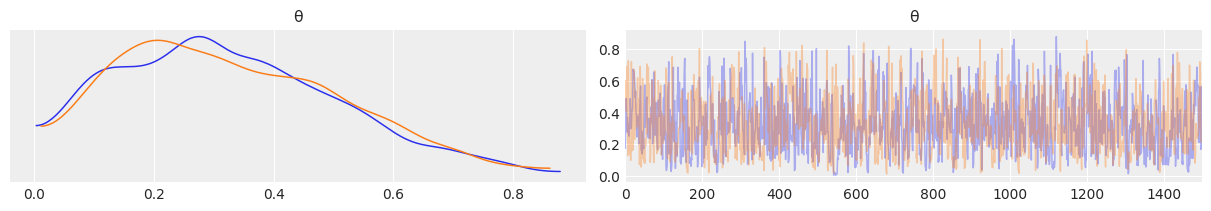

In [594]:
az.plot_trace(az.from_numpyro(mcmc), compact=False)
plt.show()

In [595]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         θ      0.33      0.18      0.31      0.05      0.61   1051.12      1.00

Number of divergences: 0


#### Posterior-based decisions

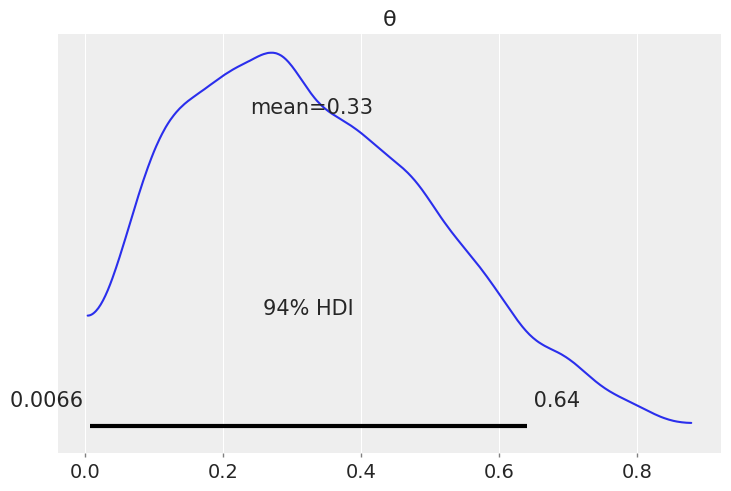

In [596]:
az.plot_posterior(az.from_numpyro(mcmc))
plt.show()

<AxesSubplot:title={'center':'θ'}>

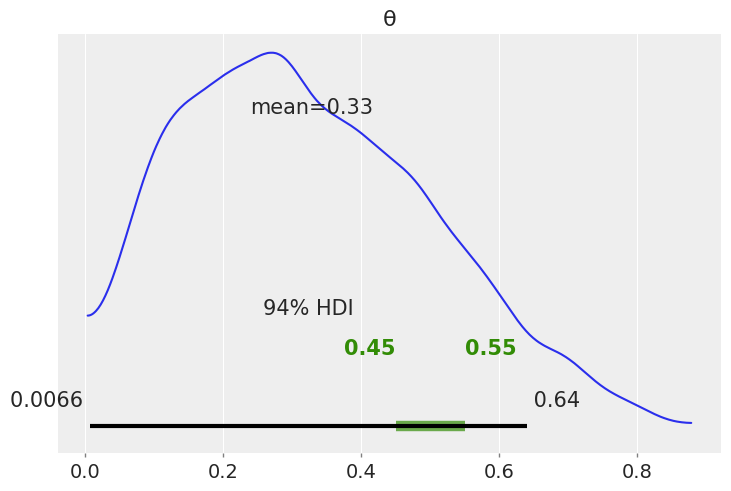

In [597]:
az.plot_posterior(az.from_numpyro(mcmc), rope=[0.45, .55])

<AxesSubplot:title={'center':'θ'}>

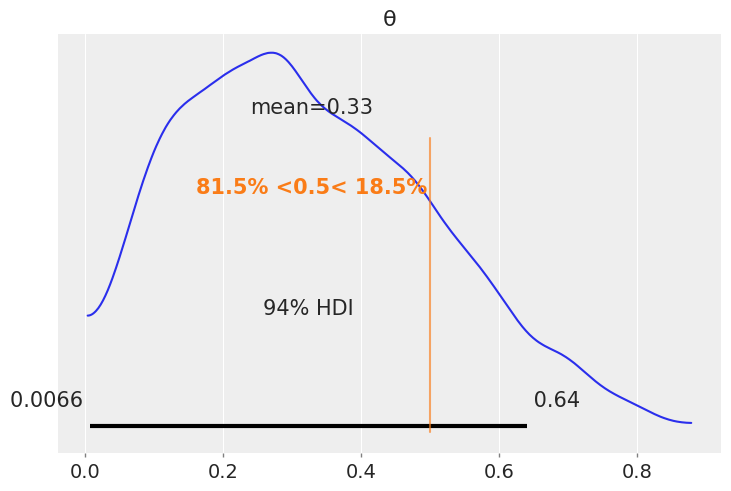

In [598]:
az.plot_posterior(az.from_numpyro(mcmc), ref_val=0.5)

In [599]:
mcmc.get_samples(group_by_chain=True)

{'θ': DeviceArray([[0.17285858, 0.32812756, 0.48738322, ..., 0.16604272,
               0.4787685 , 0.5638707 ],
              [0.57522225, 0.6004805 , 0.4808577 , ..., 0.22368269,
               0.21266927, 0.21266927]], dtype=float32)}

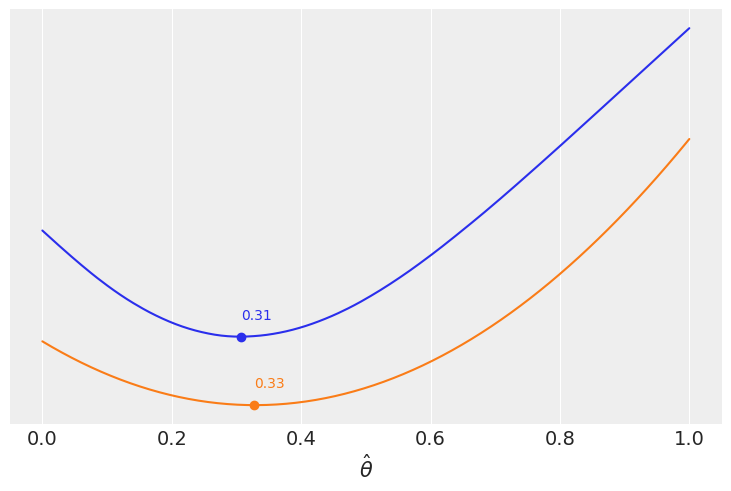

In [600]:
grid = jnp.linspace(start=0, stop=1, num=200)
θ_pos = mcmc.get_samples()["θ"]
lossf_a = [jnp.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [jnp.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = jnp.argmin(jnp.asarray(lossf))
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

In [601]:
jnp.mean(θ_pos), jnp.median(θ_pos)

(DeviceArray(0.32869053, dtype=float32),
 DeviceArray(0.30531082, dtype=float32))

Text(0.5, 0, '$\\hat \\theta$')

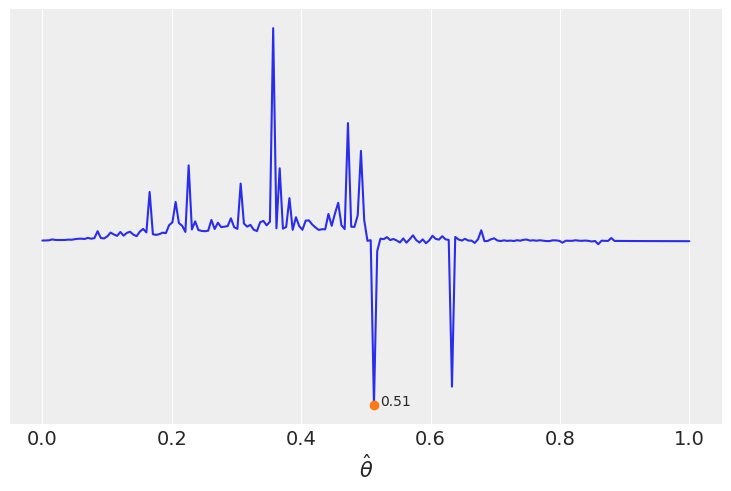

In [602]:
lossf = []
for i in grid:
    if i < 0.5:
        f = jnp.mean(jnp.pi * θ_pos / jnp.abs(i - θ_pos))
    else:
        f = jnp.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = jnp.argmin(jnp.asarray(lossf))
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

## Gaussian inferences

In [603]:
data = pd.read_csv('../data/chemical_shifts.csv', header=None)
data.head()

,0
0,51.06
1,55.12
2,53.73
3,50.24
4,52.05


In [604]:
data = jnp.asarray(data)
data.shape

(48, 1)

([<matplotlib.axis.YTick at 0x158da8a90>], [Text(0, 0, '')])

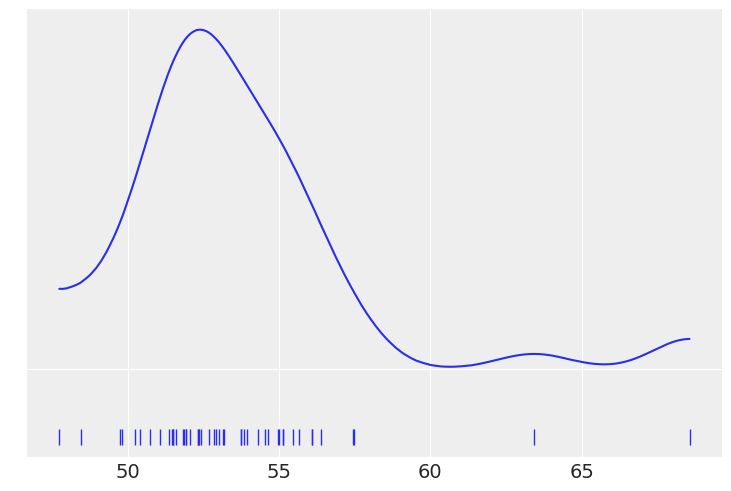

In [605]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

 <img src="./imgs/B11197_02_08.png" width="500">

In [615]:
def model(N=100, obs=None):
    μ = numpyro.sample('μ', dist.Uniform(low=40., high=70.))
    σ = numpyro.sample('σ', dist.HalfNormal(scale=10.))
    with numpyro.plate("N", N):
        numpyro.sample('y', dist.Normal(loc=μ, scale=σ), obs=obs)

    
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=2)
mcmc2.run(random.PRNGKey(seed), obs=data)

sample: 100%|██████████████████████████| 1000/1000 [00:00<00:00, 5370.28it/s, 3 steps of size 6.60e-01. acc. prob=0.93]


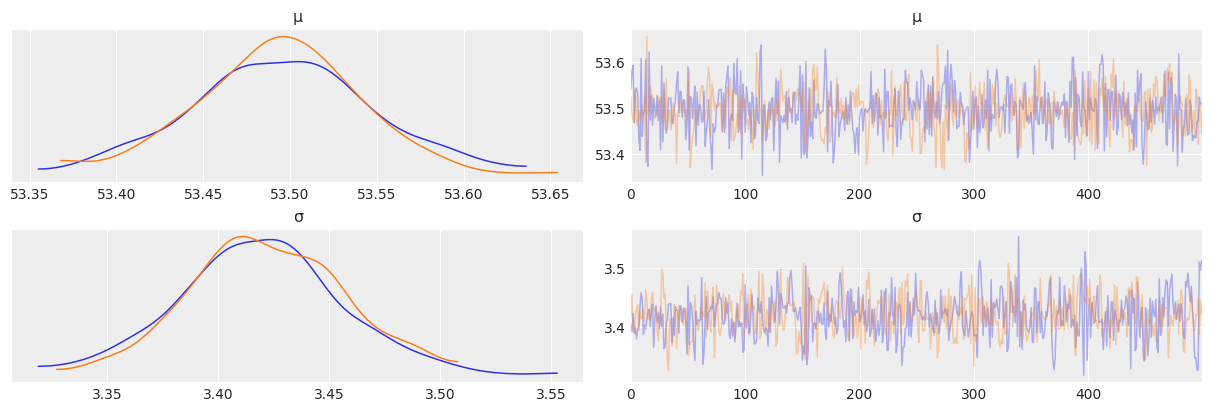

In [616]:
az.plot_trace(az.from_numpyro(mcmc2), compact=False)
plt.show()

array([<AxesSubplot:xlabel='μ', ylabel='σ'>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

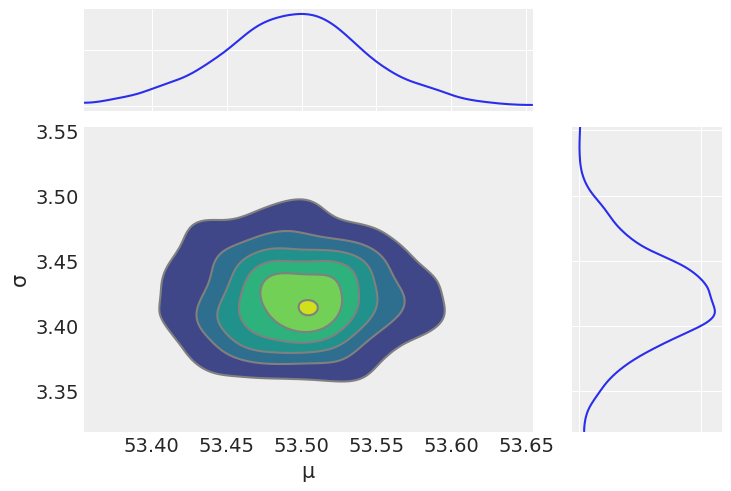

In [617]:
az.plot_joint(az.from_numpyro(mcmc2), var_names=['μ', 'σ'], kind='kde', fill_last=False)

In [618]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         μ     53.49      0.05     53.50     53.40     53.57    787.94      1.00
         σ      3.42      0.04      3.42      3.36      3.48    685.76      1.00

Number of divergences: 0


In [619]:
az.summary(mcmc2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.495,0.049,53.405,53.594,0.002,0.001,795.0,675.0,1.01
σ,3.420,0.035,3.356,3.491,0.001,0.001,693.0,579.0,1.00


---

In [620]:
prior = Predictive(mcmc2.sampler.model, num_samples=500)
prior_p = prior(random.PRNGKey(seed), obs=data)

In [634]:
pred = Predictive(model=mcmc2.sampler.model, posterior_samples=mcmc2.get_samples(), return_sites=['y'])
post_p = pred(random.PRNGKey(seed), N=100)

In [635]:
post_p['y'] = post_p['y'].squeeze()
post_p['y'] = jnp.expand_dims(post_p['y'], axis=1)
post_p['y'].shape

(1000, 1, 100)

In [636]:
jnp.sort(post_p['y'][0])

DeviceArray([[44.29414 , 44.349854, 46.441837, 46.689426, 46.796425,
              47.03588 , 47.583427, 47.596024, 48.212406, 48.726635,
              48.813835, 48.84052 , 49.055523, 49.085613, 49.60701 ,
              49.714584, 49.80934 , 49.83368 , 49.943848, 50.031883,
              50.160152, 50.25194 , 50.320923, 50.334843, 50.518284,
              50.518463, 50.6463  , 50.69864 , 50.728085, 50.96986 ,
              51.064117, 51.330784, 51.572712, 51.629684, 51.821022,
              51.835228, 51.87946 , 51.93214 , 52.314796, 52.3805  ,
              52.59526 , 52.771126, 52.853275, 52.88644 , 53.019768,
              53.135284, 53.27581 , 53.30327 , 53.48876 , 53.51001 ,
              53.626865, 53.722065, 53.72291 , 53.811417, 53.82796 ,
              53.831795, 53.83189 , 53.83466 , 54.084534, 54.088604,
              54.338524, 54.603535, 54.712193, 54.74976 , 54.75797 ,
              54.77956 , 54.86422 , 54.87436 , 54.945034, 54.96186 ,
              55.11813 , 55.122982

In [637]:
# samples = az.from_numpyro(mcmc2, prior=prior_p, posterior_predictive=post_p)
samples = az.from_numpyro(mcmc2, posterior_predictive=post_p)
# az.summary(samples)

In [638]:
samples.groups()

['posterior',
 'posterior_predictive',
 'log_likelihood',
 'sample_stats',
 'observed_data']

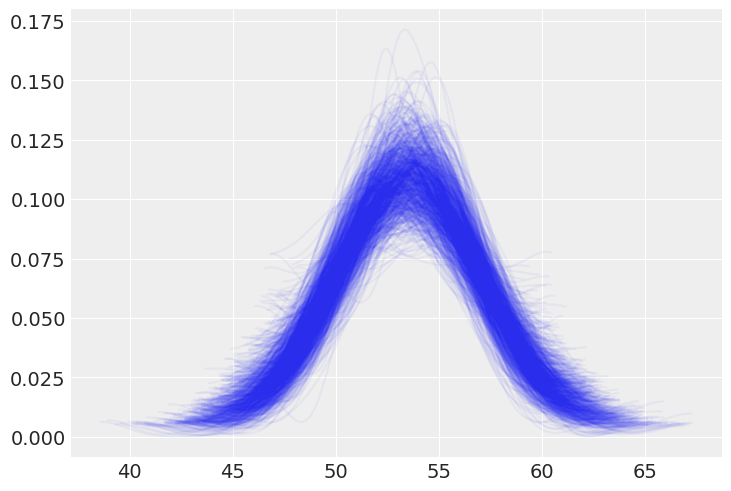

In [639]:
fig, ax = plt.subplots()
for i in post_p['y']:
    ax = az.plot_kde(i, ax=ax, plot_kwargs={'alpha': 0.05})

<AxesSubplot:xlabel='y'>

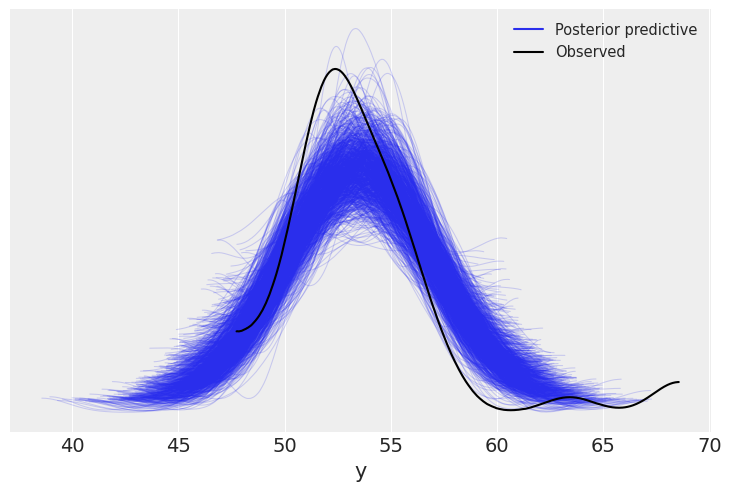

In [640]:
az.plot_ppc(samples, data_pairs={"y": "y"}, mean=False, observed=True)

---

In [ ]:
for i in range(50):
    plt.plot(, mu[i], "k", alpha=0.3)

In [39]:


# mean_prior_pred = jnp.mean(prior_predictions)
# hpdi_prior_pred = hpdi(prior_predictions, 0.9)

posterior = mcmc2.get_samples()
posterior_predictions = Predictive(model, posterior)(rng_key, data=data)
samples = az.from_numpyro(mcmc2, prior=prior_predictions, posterior_predictive=posterior_predictions)
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.558,0.493,52.547,54.416,0.020,0.014,588.0,660.0,1.0
σ,3.547,0.378,2.926,4.301,0.016,0.011,564.0,571.0,1.0


array([<AxesSubplot:title={'center':'μ'}>,
       <AxesSubplot:title={'center':'σ'}>], dtype=object)

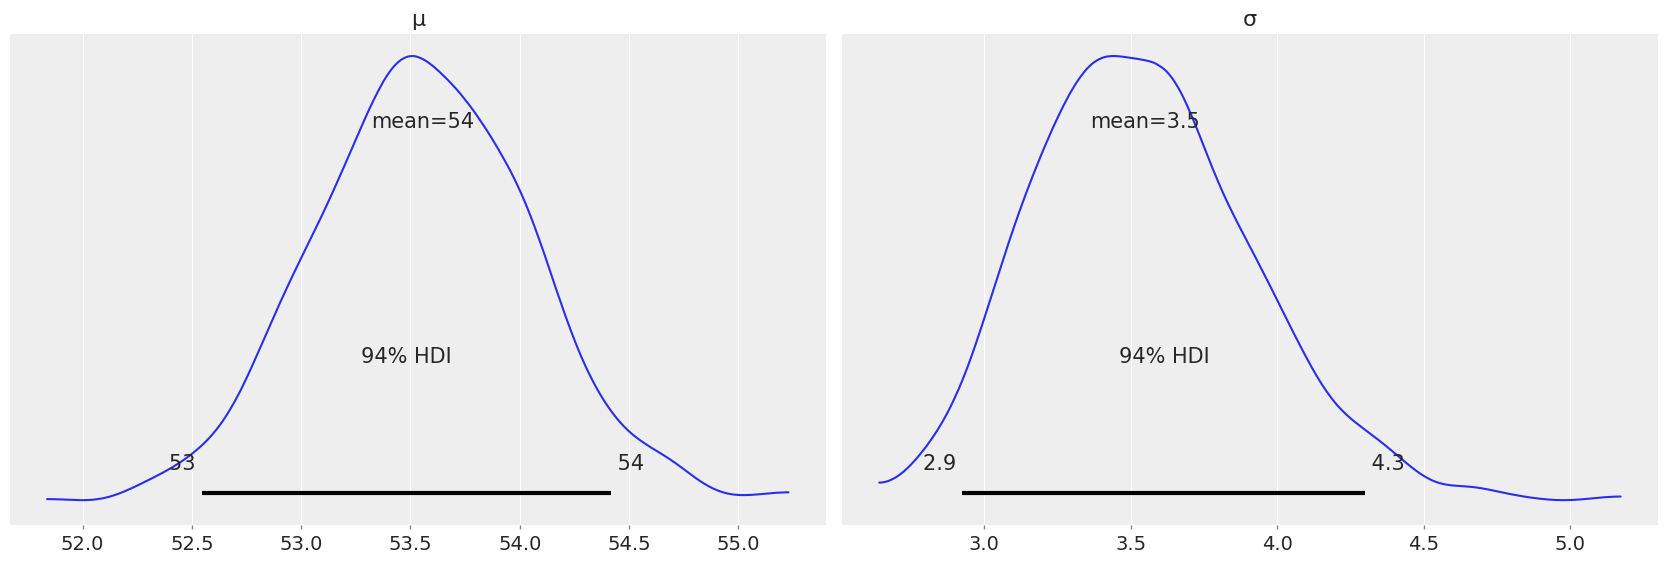

In [44]:
az.plot_posterior(data_ppc)

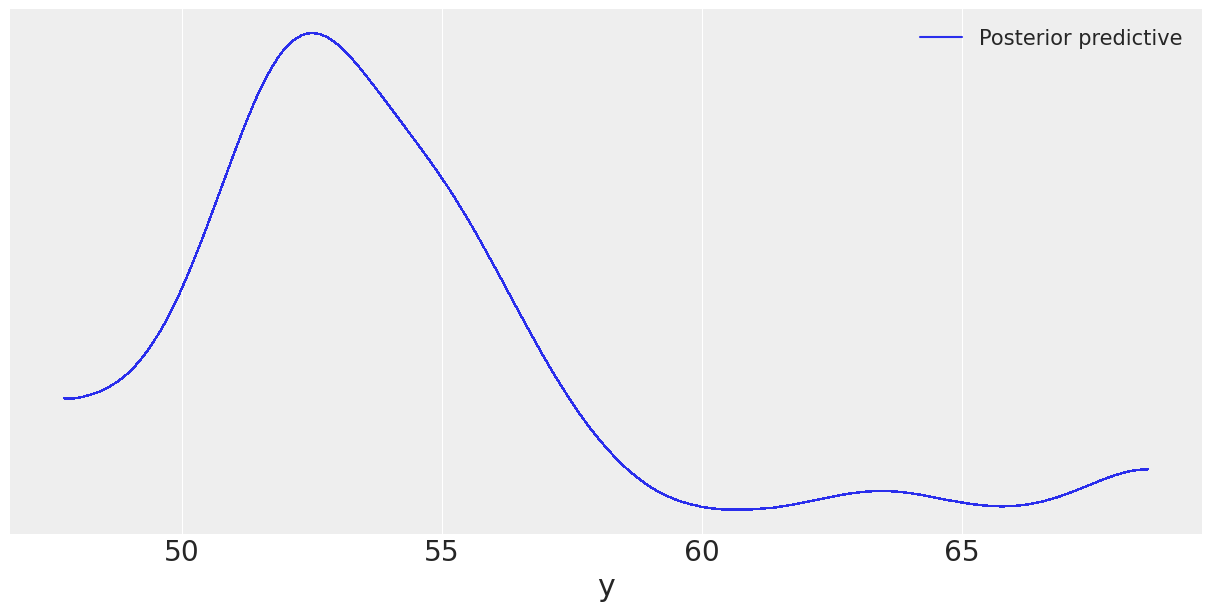

In [41]:
data_ppc = az.from_numpyro(mcmc2, prior=prior_predictions, posterior_predictive=posterior_predictions)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False, observed=False)

In [47]:
post = mcmc2.get_samples(group_by_chain=True)
pred = Predictive(mcmc2.sampler.model, mcmc2.get_samples())

In [50]:
p_post = pred(random.PRNGKey(1), data)

In [52]:
m11_4_pe_az = az.from_numpyro(mcmc2)

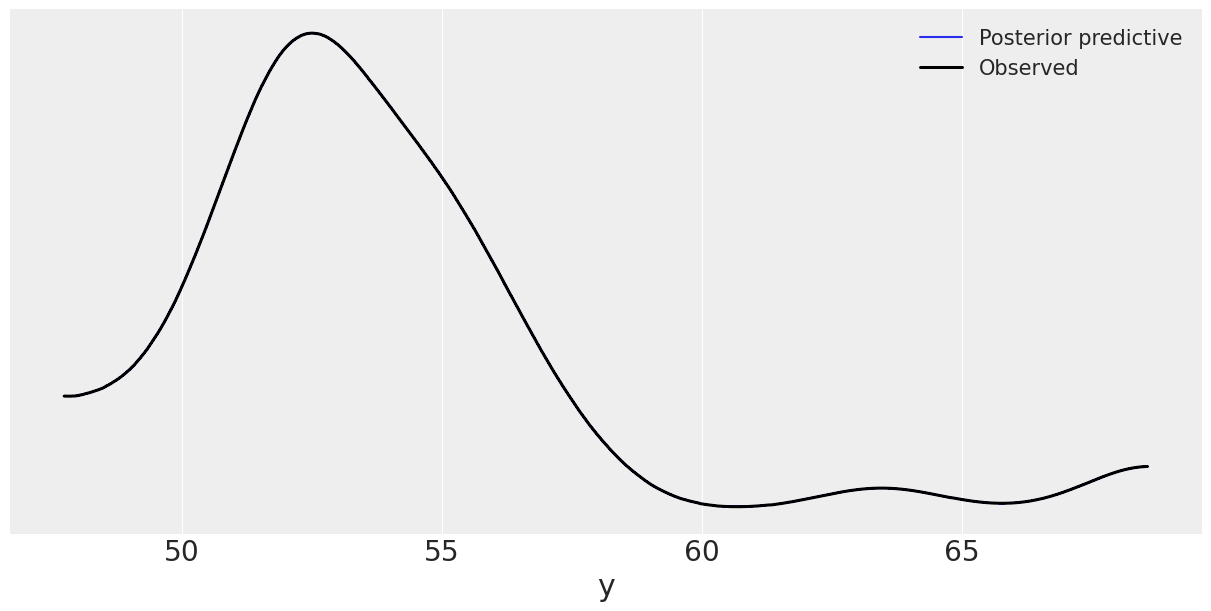

In [55]:
data_ppc = az.from_numpyro(mcmc2, prior=prior_predictions, posterior_predictive=p_post)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False, observed=True)

In [ ]:
az.summary(trace_g)

In [ ]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

In [ ]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.savefig('B11197_02_11.png', dpi=300)

### Robust inferences

In [ ]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('B11197_02_12.png', dpi=300)

 <img src="B11197_02_13.png" width="500">

In [ ]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

In [ ]:
az.plot_trace(trace_t)
plt.savefig('B11197_02_14.png', dpi=300)

In [ ]:
az.summary(trace_t)

In [ ]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)
plt.savefig('B11197_02_15.png', dpi=300)

# Tips example

In [ ]:
tips = pd.read_csv('../data/tips.csv')
tips.tail()

In [ ]:
sns.violinplot(x='day', y='tip', data=tips)
plt.savefig('B11197_02_16.png', dpi=300)

In [ ]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [ ]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)
plt.savefig('B11197_02_17.png', dpi=300)

In [ ]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('B11197_02_18.png', dpi=300)

# Hierarchical Models

 <img src="B11197_02_19.png" width="500">

In [ ]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [ ]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

In [ ]:
az.plot_trace(trace_h)
plt.savefig('B11197_02_20.png', dpi=300)

In [ ]:
az.summary(trace_h)

In [ ]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()
plt.savefig('B11197_02_21.png', dpi=300)

In [ ]:
cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [ ]:
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)

In [ ]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)

In [ ]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)